<a href="https://colab.research.google.com/github/SiLiKhon/HEPStatsSeminar/blob/master/SimpleMLFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's do a Maximum Likelihood fit!


---


We'll need an extra package called `probfit` which is not available by default. It takes some time to install, so please run the installation command now:

In [1]:
!pip install probfit

## What we'll need


---



*   ### Get and select the data
*   ### Define the likelihood function
*   ### Maximize it (minimize negative likelihood)
*   ### Plot the result



In [0]:
# We'll store and handle our data with numpy.
#
# Also, we'll start by working with 'toy' data, i.e. we are
# going to randomly generate our data - we'll use numpy for
# that as well.
import numpy as np

# The plotting will be done in matplotlib:
import matplotlib.pyplot as plt

# And we need this %matplotlib magic call so that the result
# is plotted automatically after cell exectution,
# without having to write 'plt.show()' explicitly each time:
%matplotlib inline

## Toy data


---


In reality we don't usually detect just the decays we are looking for. Usually, there are also other processes that have the same signature as the process of interest, and there is no deterministic way to tell them apart.


Let's emulate this in our toy data!

In [3]:
# Say, there's some particle with a mass of 125.18 GeV,
# which we can only measure with an uncertainty of 15 GeV:
signal = np.random.normal(loc=125.18, scale=15., size=10000)

# Then, imagine there are some continuous backgound processes
# with the same signature, which contribute to our particle
# mass measurement and are distributed as decaying exponent:
background = np.random.exponential(scale=80., size=90000)

# In real life there's no deterministic way to tell them apart,
# as they are 'shuffled' together:
data = np.concatenate([signal, background])
np.random.shuffle(data)

print("data.shape = {}".format(data.shape))
print("data = {}".format(data))

data.shape = (100000,)
data = [193.76507314  93.15063058  68.18815235 ... 214.58647969 235.50053469
 319.17791603]


Now, `data` is a 1-dimentional array each element of which represents distinct mass measurements. Let's see what it looks like:

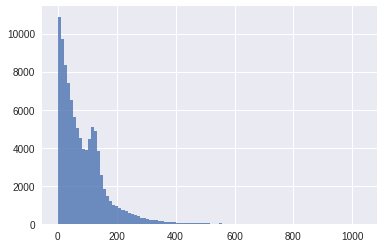

In [4]:
# Plotting a histogram of data with 100 bins.
# ('alpha=0.8' is just a little drawing tweak making
# our histogram 80% opaque / 20% transparent)
plt.hist(data, bins=100, alpha=0.8);

OK, that's nice, but we probably don't need such a wide range. Let's only select the data from 10 to 200 GeV:

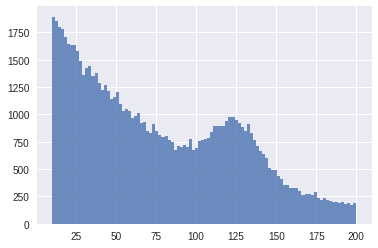

In [5]:
# We'll define a tuple with our selection range, as
# this will come in handy later
mass_bound = (10., 200.)

data = data[(data > mass_bound[0]) & (data < mass_bound[1])]
plt.hist(data, bins=100, alpha=0.8);

## Defining the model PDF and Likelihood functions


---


OK, remember we installed something at the beginning of the section? It was `probfit` — a package that makes PDF and Likelihood definition realy easy (see [this page](https://probfit.readthedocs.io/en/latest/index.html) for more details; they also have a good [tutorial here](http://nbviewer.ipython.org/urls/raw.github.com/scikit-hep/probfit/master/tutorial/tutorial.ipynb)). Let's import the package:

In [0]:
import probfit

PDFs can just be python functions with the following signature:

`function_name(x, param1, param2, ...)`

However, one has to make sure they integrate up to 1:
$$\int_{\text{domain}}\text{PDF}(x)dx = 1$$

Since we've selected our data to be in the interval $(10, 200)~$GeV, we have to normalize our PDFs such that
$$\int_{10~\text{GeV}}^{200~\text{GeV}}\text{PDF}(x)dx = 1$$

As our data is a mixture of a peaking signal and a continuous background, we'll define the PDF in the following form:
$$\text{PDF}(x|m,\sigma,k, f_{\text{sig}}) = 
f_{\text{sig}}\cdot N(x|m, \sigma) +
(1 - f_{\text{sig}})\cdot k e^{-kx},$$
where:


*   $x$ is the value of mass from an individual measurement
*   $m$ is the actual mass of the decaying particle
*   $sigma$ is detector resolution
*   $N(x|m, \sigma)$ is normal (Gaussian) distribution
*   $k$ is the empirical background slope
*   $f_{\text{sig}}$ is the fraction of signal in the mixture



In [0]:
# For the Gaussian we'll use the function already defined in
# probfit and just wrap it around our custom python function
# to rename the parameters
def SignalPDF(x, mass, sigma):
  return probfit.gaussian(x, mass, sigma)

# As for the exponential function, we'll define it ourselves
def BgPDF(x, exp_slope):
  return exp_slope * np.exp(-exp_slope * x)

# So far our functions are normalized differently:
#     SignalPDF is normalized for x in [-infinity, +infinity]
#     BgPDF is normalized for x in [0 GeV, +infinity]
# We need them both to be normalized for x in [10, 200] GeV.

# Luckily, probfit has a convinient 'Normalize' class for that:
SignalPDF_normed = probfit.Normalized(SignalPDF, mass_bound)
BgPDF_normed     = probfit.Normalized(BgPDF    , mass_bound)

# There's also a ready to use class to combine several PDFs in a sum:
ModelPDF = probfit.AddPdfNorm(SignalPDF_normed,
                              BgPDF_normed,
                              facname=['signal_fraction'])
# OK, our PDF is ready!

Now we have to define the likelihood function for a set of measurements $\{x_i\}$:
$$\mathscr{L}(m,\sigma,k, f_{\text{sig}}) = \prod_i{\text{PDF}(x_i|m,\sigma,k, f_{\text{sig}})}$$

There's a ready to use class for that as well:

In [0]:
unbinned_likelihood = probfit.UnbinnedLH(ModelPDF, data)

In [0]:
import iminuit

In [37]:
print(iminuit.describe(ModelPDF))

['x', 'mass', 'sigma', 'exp_slope', 'signal_fraction']


In [0]:
initial_par_values = dict(
  mass           =120.  ,
  sigma          = 25.  ,
  exp_slope      =  0.01,
  signal_fraction=  0.4 ,
)

limits = dict(
  limit_mass           =(50. , 200.),
  limit_sigma          =( 3. , 150.),
  limit_exp_slope      =(1e-4,   1.),
  limit_signal_fraction=( 0. ,   1.),
)

errors = dict(
  error_mass           =10.  ,
  error_sigma          =10.  ,
  error_exp_slope      =0.005,
  error_signal_fraction=0.2  ,
)

minuit = iminuit.Minuit(
            unbinned_likelihood, **initial_par_values, **limits, **errors)

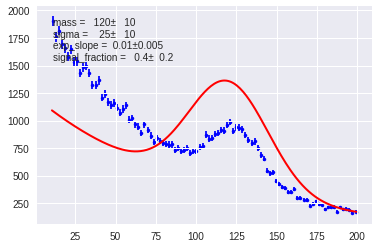

In [41]:
unbinned_likelihood.draw(minuit=minuit);

In [42]:
%timeit -n1 -r1 minuit.migrad()

FCN = 417366.52378449484 
 TOTAL NCALL = 154 
 NCALLS = 154 
 
 
 EDM = 2.7915249805413848e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,124.91,0.314872,,,50,200,No
1,sigma,15.7751,0.357811,,,3,150,No
2,exp_slope,0.0125102,0.00010805,,,0.0001,1,No
3,signal_fraction,0.126126,0.00305664,,,0,1,No


1 loop, best of 1: 34.1 s per loop


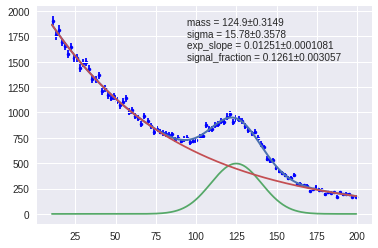

In [47]:
unbinned_likelihood.draw(minuit=minuit, parts=True, parmloc=(0.45, 0.95));

In [48]:
!pip install Cython
%load_ext Cython

In [0]:
%%cython

cimport cython
from libc.math cimport exp, M_PI, sqrt

@cython.binding(True)
def gauss_pdf_cython(double x, double mass, double sigma):
  return 1 / sqrt(2 * M_PI) / sigma * exp(-(x - mass)**2 / 2. / sigma**2)

@cython.binding(True)
def exp_pdf_cython(double x, double exp_slope):
  return exp(-exp_slope * x) * exp_slope

In [50]:
gauss_pdf_cython_normed = probfit.Normalized(gauss_pdf_cython, mass_bound)
exp_pdf_cython_normed   = probfit.Normalized(exp_pdf_cython  , mass_bound)


ModelPDF_cython = probfit.AddPdfNorm(gauss_pdf_cython_normed,
                                     exp_pdf_cython_normed,
                                     facname=['signal_fraction'])
print(iminuit.describe(ModelPDF_cython))

['x', 'mass', 'sigma', 'exp_slope', 'signal_fraction']


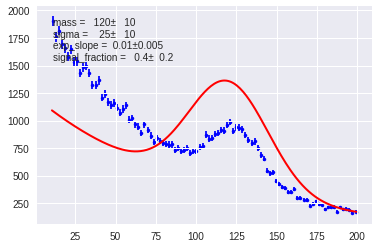

In [51]:
unbinned_likelihood_cython = probfit.UnbinnedLH(ModelPDF_cython, data)

minuit_cython = iminuit.Minuit(
                    unbinned_likelihood_cython,
                    **initial_par_values, **limits, **errors)

unbinned_likelihood_cython.draw(minuit=minuit_cython);

In [52]:
%timeit -n1 -r1 minuit_cython.migrad()

FCN = 417366.5237844946 
 TOTAL NCALL = 154 
 NCALLS = 154 
 
 
 EDM = 2.7922205886891984e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,124.91,0.314872,,,50,200,No
1,sigma,15.7751,0.357811,,,3,150,No
2,exp_slope,0.0125102,0.00010805,,,0.0001,1,No
3,signal_fraction,0.126126,0.00305664,,,0,1,No


1 loop, best of 1: 14.7 s per loop


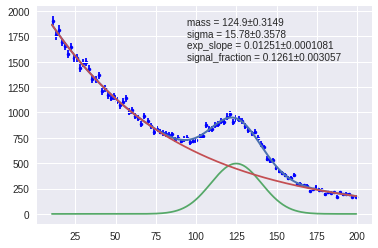

In [53]:
unbinned_likelihood_cython.draw(minuit=minuit_cython, parts=True, parmloc=(0.45, 0.95));